Tutorial 7: Data

In this example, we’ll use the ‘imaging’ module to simulate Imaging of a strong lens made using a Tracer. By simulate, we mean that it will appear as if we had observed it using a real telescope, with this example making an image representative of Hubble Space Telescope imaging.

In [2]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

print (al.__version__)

1.1.4


In [3]:
#Lens parameters

z_lens = 0.035
z_source = 2.1

D_l = cosmo.angular_diameter_distance(z_lens)
D_s = cosmo.angular_diameter_distance(z_source)
D_ls = cosmo.angular_diameter_distance_z1z2(z_lens, z_source)

#Useful constants
metre2Mpc = (1*u.m).to(u.Mpc)/u.m           #Constant factor to convert metre to Mpc.
kg2Msun = (1*u.kg/M_sun)*u.solMass/u.kg     #Constant factor to convert kg to Msun

G_Mpc = G*(metre2Mpc)**3/kg2Msun            #Gravitational constant in Mpc³/(Msun s²)
c_Mpc = c*metre2Mpc                         #Speed of light in Mpc/s

#MGE parameters
#Reading data
Surf_mge, sigma, qObs = np.loadtxt('/home/carlos/Documents/Dados Projeto/ESO325/Results/ESO325 MGE and JAM (07-07-20)/Codes/JAM Input.txt', unpack=True)

#Converting and computing some quantities
Surf_mge = Surf_mge*(u.solLum/u.pc**2)                         #Surface Luminosity in L_sun/pc²
sigma = sigma*u.arcsec                                         #Sigma in arcsec
sigma_pc = (sigma*D_l).to(u.pc, u.dimensionless_angles())      #Convert sigma in arcsec to sigma in pc
Lum_mge = 2*np.pi*Surf_mge*(sigma_pc**2)*qObs                  #Total Luminosity per gaussian component




#Defining inputs for the integral bellow
ML = 2.75*(u.solMass/u.solLum)                                 #Mass-to-light ratio in kg/L_sun
i = np.deg2rad(80)*u.rad                                       #Inclination angle in rad
M0 = ML*Lum_mge                                                #Mass per gaussian component in kg
q0 = np.sqrt(qObs**2 - np.cos(i)**2)/np.sin(i)                 #Deprojected axial ratio
sigma0 = (sigma).to(u.rad)                                     #Sigma per gaussian in rad



To simulate an image, we need to model the telescope’s optics. We’ll do this by convolving the image with a Point-Spread Function using a Kernel object, which we can simulate as a Gaussian.

In [4]:
psf = al.Kernel.from_gaussian(shape_2d=(11, 11), sigma=0.1, pixel_scales=0.1)

To simulate Imaging dataset, we use a Grid, like usual.

In [5]:
grid = al.Grid.uniform(shape_2d=(150, 150), pixel_scales=0.1, sub_size=1)

print('Luminosity per gaussian:\n', Lum_mge)
print('\nMass-to-light:', ML)
print('\nMass per gaussian:\n', M0)
print('\nSigma per gaussian:\n', sigma0)
print('\nAxial Ratio deprojected:\n', q0)


Luminosity per gaussian:
 [3.95990609e+07 2.14493871e+08 2.59545468e+09 5.99318897e+09
 1.45617772e+10 2.46067706e+10 7.80698320e+10] solLum

Mass-to-light: 2.75 solMass / solLum

Mass per gaussian:
 [1.08897418e+08 5.89858146e+08 7.13750036e+09 1.64812697e+10
 4.00448874e+10 6.76686192e+10 2.14692038e+11] solMass

Sigma per gaussian:
 [1.84714013e-07 8.54479265e-07 1.82864448e-06 3.41875579e-06
 6.40943079e-06 1.31994209e-05 3.44875412e-05] rad

Axial Ratio deprojected:
 [0.84490958 0.84490958 0.84490958 0.74087624 0.74087624 0.74087624
 0.83497908]


Now, lets setup our lens galaxy, source galaxy and Tracer.

In [6]:
mass_profile = al.mp.MGE(centre=(0.0, 0.0))
mass_profile.MGE_comps(M=M0.value, sigma=sigma0.value, q=q0.value, z_l=z_lens, z_s=z_source)

lens_galaxy = al.Galaxy(
    redshift=0.035,
    mass=mass_profile,
)


source_galaxy = al.Galaxy(
    redshift=2.1,
    light=al.lp.EllipticalSersic(
        centre=(0.2, 0.1),
        elliptical_comps=(0.3, 0.111111),
        intensity=2.0,
        effective_radius=1.0,
        sersic_index=1,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

In [7]:
len(grid)

22500

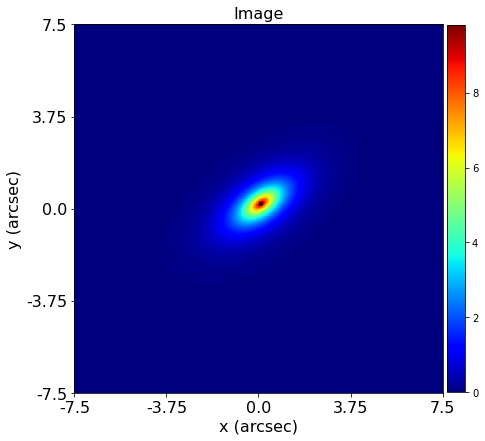

In [8]:
aplt.Galaxy.image(galaxy=source_galaxy, grid=grid)

Lets look at the Tracer’s image - this is the image we’ll be simulating.

Critical curve could not be calculated due to an unphysical mass model


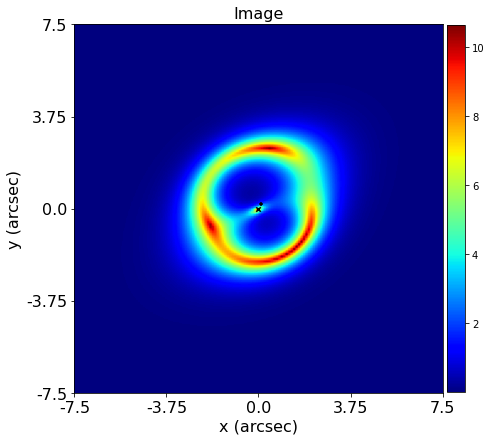

330.1190925330011


In [9]:
time = clock()
aplt.Tracer.image(tracer=tracer, grid=grid)
print(clock() - time)

To Simulate the Imaging data, we don’t use the image plotted above. Instead, we use an image which has been generated specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we convolve the image with. This ensures edge-effects do not degrade our simulation’s PSF convolution.

In [10]:
time = clock()

normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_2d
)
print(normal_image.shape)
print(padded_image.shape)

print(clock() - time)

(22500,)
(25600,)
709.3813289280006


Now, to simulate the Imaging data, we pass the Tracer and Grid to the Imaging module’s simulate function. This adds the following effects to the image:


    Telescope optics: Using the Point Spread Function above.
    The Background Sky: Although the image that is returned is automatically background sky subtracted.
    Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.


In [11]:
time = clock()

simulator = al.SimulatorImaging(
    exposure_time_map=al.Array.full(fill_value=300.0, shape_2d=grid.shape_2d),
    psf=psf,
    background_sky_map=al.Array.full(fill_value=0.1, shape_2d=grid.shape_2d),
    add_noise=True,
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

print(clock() - time)

381.32264289700106


Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

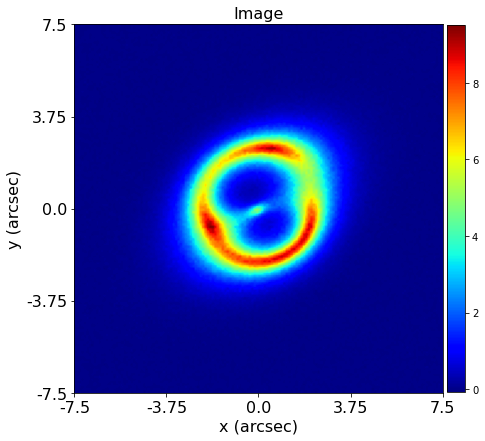

In [12]:
aplt.Imaging.image(imaging=imaging)

Finally, lets output these files to.fits files, we’ll begin to analyze them in the next tutorial!

The data path specifies where the data is output, this time in the directory ‘MGE/Data’.

Recall that we use the library pyprojroot to get a relative path to the autolens_workspace, double check this path is correct on your computer!

Setup the path to the autolens workspace, using the project pyprojroot which determines it automatically.

In [13]:
from pyprojroot import here

workspace_path = str(here())
dataset_path = f"{workspace_path}/howtolens/MGE/Data"
print("Dataset Path: ", dataset_path)

Dataset Path:  /home/carlos/autolens_workspace/howtolens/MGE/Data


In [14]:
imaging.output_to_fits(
    image_path=f"{dataset_path}/ImageNew.fits",
    noise_map_path=f"{dataset_path}/NoiseNew.fits",
    psf_path=f"{dataset_path}/PSFNew.fits",
    overwrite=True,
)

In [15]:
import autolens as al
import autolens.plot as aplt
from pyprojroot import here
import numpy as np

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.constants import G, M_sun, c
import astropy.units as u

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


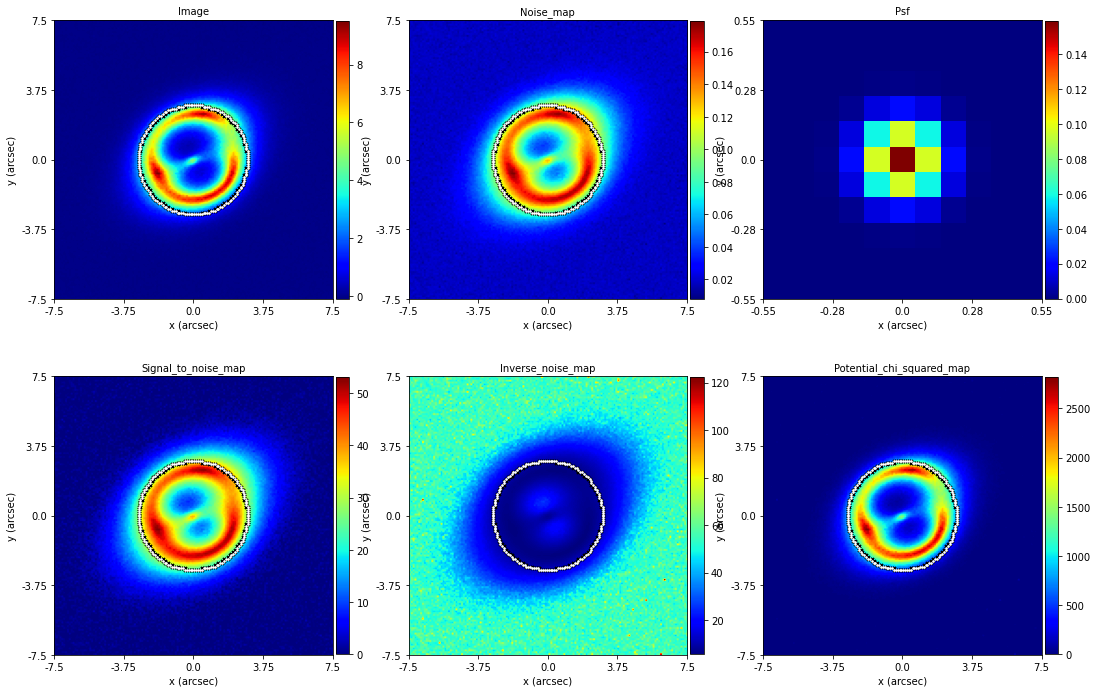

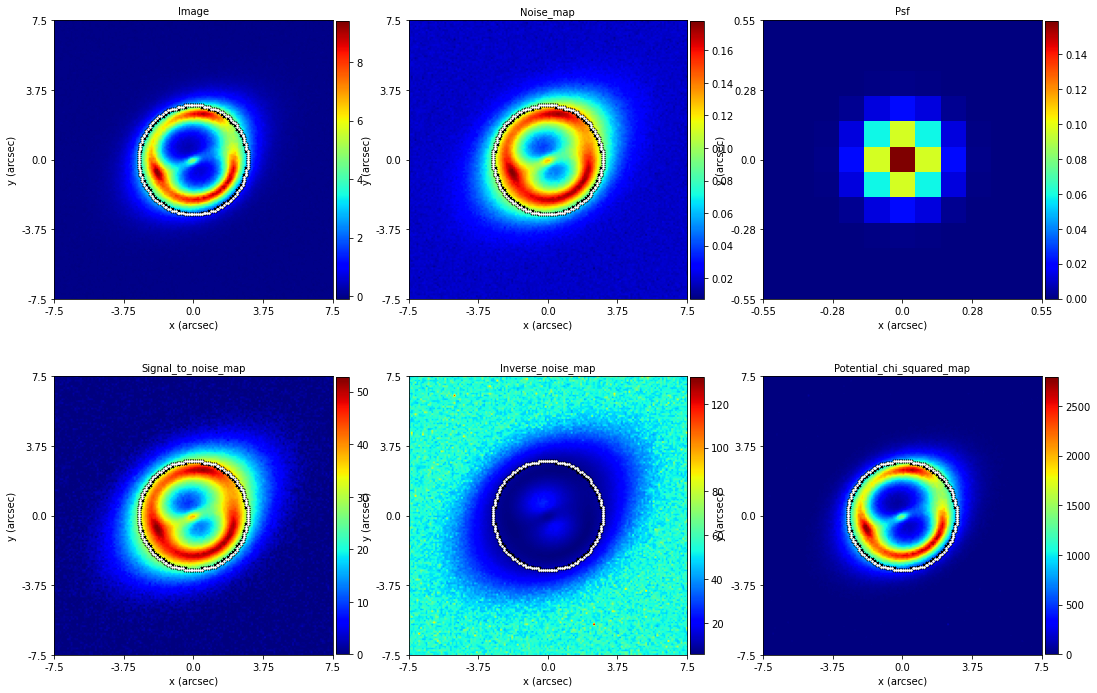

In [16]:
dataset_type = "MGE"
dataset_name = "Data"
dataset_path = f"{workspace_path}/howtolens/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageNew.fits",
    noise_map_path=f"{dataset_path}/NoiseNew.fits",
    psf_path=f"{dataset_path}/PSFNew.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=3 ,centre=(0, 0)
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask, include=aplt.Include(border=True)
)


imaging1 = al.Imaging.from_fits(
    image_path=f"{dataset_path}/ImageUnits.fits",
    noise_map_path=f"{dataset_path}/NoiseUnits.fits",
    psf_path=f"{dataset_path}/PSFUnits.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging1.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1,radius=3 ,centre=(0, 0)
)

masked_imaging1 = al.MaskedImaging(imaging=imaging1, mask=mask)

aplt.Imaging.subplot_imaging(
    imaging=imaging1, mask=mask, include=aplt.Include(border=True)
)